In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import sys
# Machine Learning model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
# Decomposition methods
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD

# Evaluation metrics
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [115]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
data = pd.read_csv("SP_500_cleaned.csv", index_col=0, parse_dates=True)

In [4]:
# Let's take a brief look at the data
data.head()

,aroon_down,aroon_up,aroon_bandwidth,bbands_lower,bbands_upper,bbandwidth_100,cci,macd_hist,obv,rsi,...,sma_20,stoch,today_value,crudeoil_open,dollar_open,fedfund_open,gold_open,treasury_3_month,treasury_10_year,tomorrow_value
2020-02-12,68.0,100.0,32.0,295.8801,310.6189,4.860288,130.3988,0.5621,152266495.0,66.5652,...,303.2495,89.2079,310.06,51.26,98.310,98.830,1567.9,1.58,1.62,309.76
2020-02-11,0.0,100.0,100.0,296.0548,309.5222,4.447791,127.2818,0.4072,150193295.0,63.8521,...,302.7885,90.4138,308.08,50.97,98.370,98.840,1573.0,1.57,1.59,310.06
2020-02-10,4.0,100.0,96.0,296.1414,308.7516,4.169399,98.2111,0.2969,147757389.0,63.0650,...,302.4465,94.0582,307.52,50.87,98.170,98.825,1573.0,1.58,1.56,308.08
2020-02-07,8.0,96.0,88.0,296.0373,308.0297,3.970553,83.4621,0.1238,145518724.0,59.8937,...,302.0335,88.6643,305.33,51.36,97.920,98.805,1567.6,1.56,1.59,307.52
2020-02-06,0.0,100.0,100.0,295.9214,307.6246,3.878147,111.6022,0.0321,147767681.0,63.5001,...,301.7730,74.0335,306.89,51.45,97.795,98.760,1556.8,1.57,1.65,305.33


In [5]:
# Let's first split the data into training and test set
# We will keep the first 60% of the data as training and the remaining 20% as test data
training_row_num = int(len(data) * 0.6)
validation_row_num = int(len(data) * 0.8)
# We will take the earlier data as training data                       
training_data = data[::-1].iloc[:training_row_num, :]
validation_data = data[::-1].iloc[training_row_num:validation_row_num, :]
test_data = data[::-1].iloc[validation_row_num:, :]

In [6]:
training_data.head()

,aroon_down,aroon_up,aroon_bandwidth,bbands_lower,bbands_upper,bbandwidth_100,cci,macd_hist,obv,rsi,...,sma_20,stoch,today_value,crudeoil_open,dollar_open,fedfund_open,gold_open,treasury_3_month,treasury_10_year,tomorrow_value
2011-02-01,0.0,100.0,100.0,57.8037,59.7096,3.243721,178.8183,-0.0395,2226406.0,65.8083,...,58.7566,51.0569,99.5604,99.24,78.130,99.46,1334.0,0.15,3.48,99.3938
2011-02-02,12.0,96.0,84.0,57.8614,59.8129,3.316785,151.2937,-0.0177,2044488.0,64.3151,...,58.8371,54.5639,99.3938,99.84,77.500,99.29,1343.5,0.16,3.52,99.6437
2011-02-03,8.0,100.0,92.0,57.8702,59.9491,3.528966,112.9154,0.0013,2188908.0,65.5768,...,58.9096,69.9509,99.6437,101.09,77.615,99.25,1336.0,0.14,3.58,99.9102
2011-02-04,4.0,100.0,96.0,57.9004,60.0899,3.711325,123.0944,0.0183,2382963.0,66.9205,...,58.9951,85.6640,99.9102,100.47,78.345,99.18,1356.4,0.15,3.68,100.5417
2011-02-07,0.0,100.0,100.0,57.9307,60.2802,3.975095,160.9721,0.0471,2618981.0,69.9167,...,59.1055,92.2863,100.5417,99.27,78.485,99.14,1348.1,0.16,3.68,101.0096


In [7]:
validation_data.head()

,aroon_down,aroon_up,aroon_bandwidth,bbands_lower,bbands_upper,bbandwidth_100,cci,macd_hist,obv,rsi,...,sma_20,stoch,today_value,crudeoil_open,dollar_open,fedfund_open,gold_open,treasury_3_month,treasury_10_year,tomorrow_value
2016-07-01,84.0,32.0,-52.0,185.3541,196.8349,6.007918,86.6485,0.0090,13719997.0,54.7954,...,191.0945,63.7571,179.7160,52.38,95.905,99.580,1329.1,0.28,1.46,178.4563
2016-07-05,80.0,28.0,-52.0,185.3635,196.5655,5.866012,39.1422,0.0923,11486970.0,51.6059,...,190.9645,81.8494,178.4563,53.22,95.745,99.520,1345.0,0.28,1.37,179.5107
2016-07-06,76.0,24.0,-52.0,185.4288,196.3182,5.705035,50.0235,0.2144,13684858.0,54.0185,...,190.8735,88.1325,179.5107,51.34,96.405,99.580,1363.5,0.27,1.38,179.3894
2016-07-07,72.0,20.0,-52.0,185.5661,195.9219,5.429162,65.6392,0.2735,11979915.0,53.6869,...,190.7440,85.5009,179.3894,52.04,96.195,99.535,1369.2,0.29,1.40,182.1141
2016-07-08,68.0,100.0,32.0,185.4989,196.0521,5.531738,119.1989,0.4842,14028461.0,59.6748,...,190.7755,83.5353,182.1141,49.81,96.320,99.525,1364.2,0.28,1.37,182.7486


In [8]:
test_data.head()

,aroon_down,aroon_up,aroon_bandwidth,bbands_lower,bbands_upper,bbandwidth_100,cci,macd_hist,obv,rsi,...,sma_20,stoch,today_value,crudeoil_open,dollar_open,fedfund_open,gold_open,treasury_3_month,treasury_10_year,tomorrow_value
2018-04-24,36.0,0.0,-36.0,236.2465,249.2235,5.346159,-60.8306,0.3600,69353660.0,44.0935,...,242.735,37.5990,233.2478,63.43,90.275,97.490,1323.2,1.87,3.00,233.8465
2018-04-25,32.0,4.0,-28.0,236.5744,249.1816,5.190754,-85.2170,0.1701,71708198.0,45.2870,...,242.878,25.9076,233.8465,62.77,90.120,97.495,1328.6,1.85,3.03,236.2509
2018-04-26,28.0,0.0,-28.0,237.1444,249.2136,4.963093,-5.9146,0.2079,73814989.0,49.9120,...,243.179,26.7405,236.2509,63.20,90.525,97.500,1320.7,1.82,3.00,236.5020
2018-04-27,24.0,72.0,48.0,237.2629,249.3791,4.979513,1.9691,0.2436,75993857.0,50.3836,...,243.321,40.3641,236.5020,62.97,90.950,97.495,1318.0,1.82,2.96,234.5707
2018-04-30,20.0,68.0,48.0,238.4509,248.8351,4.262056,-39.0317,0.1314,73847756.0,46.7379,...,243.643,54.9364,234.5707,62.97,90.955,97.490,1324.0,1.87,2.95,235.0728


In [9]:
y_train = training_data.iloc[:, -1]
X_train = training_data.iloc[:, :-1]
y_validation = validation_data.iloc[:, -1]
X_validation = validation_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]

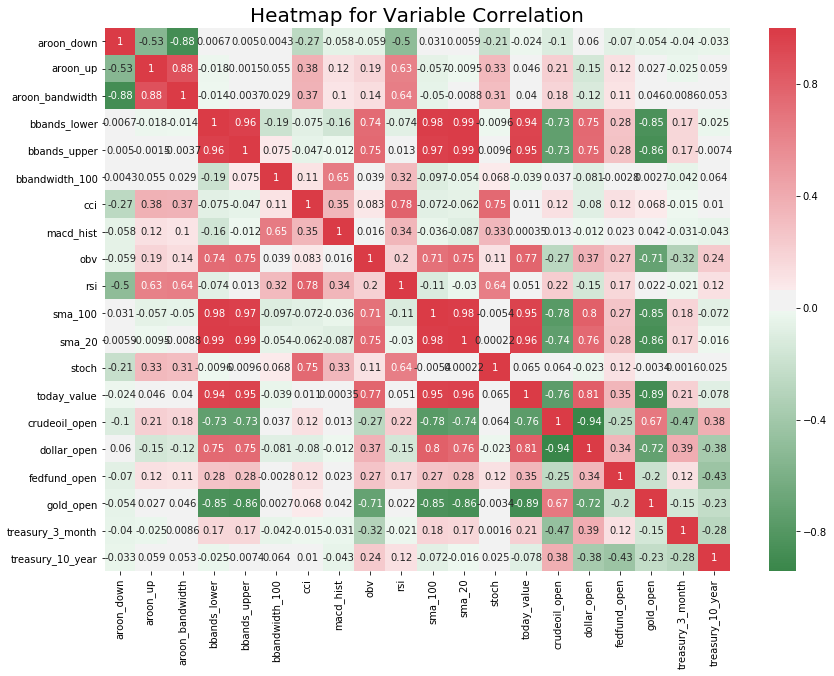

In [10]:
# Let's take a look at the correlations among variables to see if they might be correlated with each other

plt.subplots(figsize=(14,10))
cmap = sns.diverging_palette(133, 10, as_cmap=True)
sns.heatmap(X_train.corr(), cmap=cmap, annot=True)
plt.title("Heatmap for Variable Correlation", size = 20)
plt.savefig("var_heatmap.png")
plt.show()

It seems that some features are highly correlated with each other. If two values are highlt collinear, then knowing one variable will predict the other variable well.\
This is bad for building machine learning models, because the coefficients associated with that value become hard to predict

In [11]:
X_train.corr()

,aroon_down,aroon_up,aroon_bandwidth,bbands_lower,bbands_upper,bbandwidth_100,cci,macd_hist,obv,rsi,sma_100,sma_20,stoch,today_value,crudeoil_open,dollar_open,fedfund_open,gold_open,treasury_3_month,treasury_10_year
aroon_down,1.000000,-0.534317,-0.876207,0.006655,0.005015,0.004345,-0.266412,-0.058115,-0.058885,-0.496101,0.030713,0.005870,-0.214150,-0.023982,-0.101695,0.059675,-0.070286,-0.054279,-0.040268,-0.033454
aroon_up,-0.534317,1.000000,0.875545,-0.017662,-0.001503,0.055235,0.375745,0.124021,0.187685,0.626277,-0.056796,-0.009494,0.326887,0.046261,0.214667,-0.146453,0.123857,0.026676,-0.025255,0.059093
aroon_bandwidth,-0.876207,0.875545,1.000000,-0.013874,-0.003723,0.029009,0.366502,0.103927,0.140665,0.640625,-0.049937,-0.008768,0.308775,0.040083,0.180518,-0.117608,0.110790,0.046234,0.008617,0.052813
bbands_lower,0.006655,-0.017662,-0.013874,1.000000,0.964389,-0.186725,-0.075394,-0.164097,0.735837,-0.074127,0.980058,0.990668,-0.009556,0.944194,-0.731708,0.752175,0.277090,-0.847834,0.171117,-0.024939
bbands_upper,0.005015,-0.001503,-0.003723,0.964389,1.000000,0.074676,-0.047443,-0.012117,0.754283,0.012522,0.968092,0.991438,0.009580,0.948942,-0.733660,0.745047,0.283223,-0.863737,0.169634,-0.007444
bbandwidth_100,0.004345,0.055235,0.029009,-0.186725,0.074676,1.000000,0.105075,0.652360,0.038861,0.322521,-0.096894,-0.053704,0.067774,-0.038848,0.037257,-0.081136,-0.002825,0.002699,-0.042092,0.063635
cci,-0.266412,0.375745,0.366502,-0.075394,-0.047443,0.105075,1.000000,0.346137,0.082786,0.782732,-0.071758,-0.061670,0.750756,0.011382,0.120928,-0.080149,0.120463,0.068366,-0.015472,0.010193
macd_hist,-0.058115,0.124021,0.103927,-0.164097,-0.012117,0.652360,0.346137,1.000000,0.015584,0.340628,-0.036319,-0.087259,0.332633,0.000352,0.012864,-0.012447,0.022549,0.042447,-0.030956,-0.043090
obv,-0.058885,0.187685,0.140665,0.735837,0.754283,0.038861,0.082786,0.015584,1.000000,0.203955,0.707237,0.751979,0.113198,0.769046,-0.267575,0.368676,0.269180,-0.714498,-0.317166,0.236070
rsi,-0.496101,0.626277,0.640625,-0.074127,0.012522,0.322521,0.782732,0.340628,0.203955,1.000000,-0.109069,-0.030144,0.639351,0.051268,0.218382,-0.151040,0.170156,0.022462,-0.021192,0.124337


In [12]:
# Let's find variable pairs that have high correlations
def create_corr_table(dataset):
    X_train_corr_table = dataset.corr()
    corr_var_pairs = {}
    for y in X_train_corr_table.columns:
        for x in X_train_corr_table.index:
            if (abs(X_train_corr_table.loc[x, y]) > 0.9) and x!=y:
                corr_var_pairs[(x, y)] = X_train_corr_table.loc[x, y]
    return corr_var_pairs

In [13]:
corr_var_pairs = create_corr_table(X_train)

In [14]:
corr_var_pairs_series = pd.Series(corr_var_pairs)

In [15]:
corr_var_pairs_series

bbands_upper   bbands_lower     0.964389
sma_100        bbands_lower     0.980058
sma_20         bbands_lower     0.990668
today_value    bbands_lower     0.944194
bbands_lower   bbands_upper     0.964389
sma_100        bbands_upper     0.968092
sma_20         bbands_upper     0.991438
today_value    bbands_upper     0.948942
bbands_lower   sma_100          0.980058
bbands_upper   sma_100          0.968092
sma_20         sma_100          0.982731
today_value    sma_100          0.948587
bbands_lower   sma_20           0.990668
bbands_upper   sma_20           0.991438
sma_100        sma_20           0.982731
today_value    sma_20           0.955157
bbands_lower   today_value      0.944194
bbands_upper   today_value      0.948942
sma_100        today_value      0.948587
sma_20         today_value      0.955157
dollar_open    crudeoil_open   -0.942868
crudeoil_open  dollar_open     -0.942868
dtype: float64

In [16]:
# It seems that bbands_lower and bbands_higher are correlated with many other variables
# Let's see what will happen if we remove bbands_upper and bbands_lower
pd.Series(create_corr_table(X_train.drop(["bbands_upper", "bbands_lower"], axis=1)))

sma_20         sma_100          0.982731
today_value    sma_100          0.948587
sma_100        sma_20           0.982731
today_value    sma_20           0.955157
sma_100        today_value      0.948587
sma_20         today_value      0.955157
dollar_open    crudeoil_open   -0.942868
crudeoil_open  dollar_open     -0.942868
dtype: float64

Now it seems that simple moving averages are strongly correlated with each other as well as with today's value, and dollar open values are strongly and negatively correlated with crudeoil open values

I will remove some features with very high correlation with other features


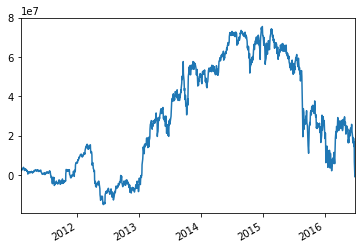

In [17]:
X_train.obv.plot()

In [18]:
# Let's find feature importance with random forest regressor
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [19]:
variable_feature_importance = {}
for i in range(len(X_train.columns)):
    variable_feature_importance[X_train.columns[i]] = rf.feature_importances_[i]

In [20]:
# Let's look at the ordered feature importance of all variables currently available for the training set
pd.Series(variable_feature_importance).sort_values(ascending=False)

today_value         0.756181
sma_100             0.238485
bbands_upper        0.002010
sma_20              0.001738
obv                 0.000260
bbands_lower        0.000155
bbandwidth_100      0.000107
gold_open           0.000106
stoch               0.000097
treasury_10_year    0.000095
rsi                 0.000094
macd_hist           0.000090
dollar_open         0.000084
cci                 0.000084
fedfund_open        0.000083
crudeoil_open       0.000083
aroon_down          0.000076
aroon_up            0.000068
aroon_bandwidth     0.000065
treasury_3_month    0.000040
dtype: float64

From the result of the feature importance, it seems that aroon variables are not important features in terms of predicting the outcome. 
* Most relevant variables are yesterday values, simple moving averages, and upper bollinger bands
* aroon, cci, macd, stoch, rsi, crudeoil, treasury, bbandwidth, gold, dollar are the least relevant variables

In [21]:
# I will form a baseline model and see the rmse value for it
y_val_pred = rf.predict(X_validation)
print("root mean squared error: {}".format(np.sqrt(mean_squared_error(y_validation, y_val_pred))))

root mean squared error: 38.618093823820836


In [22]:
# Let's run another random forest model with fewer variables
kept_cols = ['today_value', 'sma_100', 'bbands_upper', 'sma_20', 'obv', 'bbands_lower',
               'bbandwidth_100', 'gold_open', 'stoch', 'treasury_10_year', 'rsi', 'macd_hist']
rf2 = RandomForestRegressor(random_state=0)
rf2.fit(X_train[kept_cols], y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [23]:
reduced_variable_feature_importance = {}
for i in range(len(kept_cols)):
    reduced_variable_feature_importance[kept_cols[i]] = rf2.feature_importances_[i]

In [24]:
pd.Series(reduced_variable_feature_importance).sort_values(ascending=False)

today_value         0.760417
sma_100             0.234145
sma_20              0.002289
bbands_upper        0.001877
obv                 0.000285
gold_open           0.000163
bbandwidth_100      0.000152
rsi                 0.000148
stoch               0.000142
macd_hist           0.000135
treasury_10_year    0.000131
bbands_lower        0.000114
dtype: float64

In [25]:
y_val_pred_reduced = rf2.predict(X_validation[kept_cols])
print("root mean squared error: {}".format(np.sqrt(mean_squared_error(y_validation, y_val_pred_reduced))))

root mean squared error: 38.990770897750984


The RMSE values for X_train with fewer rows are similar to RMSE values for X_train with all values.


#### Now here's the question. Is there any latent variables we are missing, and if we should resort to decomposition methods such as PCA, LDA, or Factor Analysis

We can iteratively test all these methods to see if they can yield a better rmse score than what we already achieved with the baseline model

In [45]:
# Let's build a function that iteratively spits out rmse score for predictions with PCA components

In [27]:
# Let's build a function that iteratively spits out rmse score for predictions with PCA components
def PCA_evaluation(X_train, y_train, X_validation, y_validation, model):
    var_num = len(X_train.columns) # Maximum number of components is equal to the number of variables
    rmse_scores = [] # to store the rmse values
    for n_components in range(1, var_num+1):
        pca = PCA(n_components = n_components, random_state = 0)
        X_train_pca = pca.fit_transform(X_train)
        X_validation_pca = pca.transform(X_validation)
        model.fit(X_train_pca, y_train)
        y_val_pred = model.predict(X_validation_pca)
        print("root mean squared error for {} components: {}".format(n_components, np.sqrt(mean_squared_error(y_validation, y_val_pred))))
        rmse_scores.append(np.sqrt(mean_squared_error(y_validation, y_val_pred)))
    return rmse_scores

In [29]:
# Let's see if having PCA produces lower RMSE values for Decision Tree
dt = DecisionTreeRegressor(random_state=0)
PCA_rmse_evaluations_dt = PCA_evaluation(X_train, y_train, X_validation, y_validation, dt)

root mean squared error for 1 components: 65.38699141140931
root mean squared error for 2 components: 54.564438031450486
root mean squared error for 3 components: 53.644344960759945
root mean squared error for 4 components: 54.985241476933844
root mean squared error for 5 components: 44.82042052535556
root mean squared error for 6 components: 47.716669270323436
root mean squared error for 7 components: 46.88755874503279
root mean squared error for 8 components: 47.015906894573085
root mean squared error for 9 components: 47.06068717520174
root mean squared error for 10 components: 50.99848777323126
root mean squared error for 11 components: 49.629693910414446
root mean squared error for 12 components: 47.03858578900966
root mean squared error for 13 components: 47.85661658183298
root mean squared error for 14 components: 47.712597990851606
root mean squared error for 15 components: 50.04078259523201
root mean squared error for 16 components: 49.1450971690759
root mean squared error for

In [30]:
# Let's test this method again on Random forest regressor
rf = RandomForestRegressor(random_state=0)
PCA_rmse_evaluations_dt = PCA_evaluation(X_train, y_train, X_validation, y_validation, rf)

root mean squared error for 1 components: 63.77391420112304
root mean squared error for 2 components: 53.88652803595703
root mean squared error for 3 components: 53.82982592577127
root mean squared error for 4 components: 53.50255425571675
root mean squared error for 5 components: 45.748932284724866
root mean squared error for 6 components: 46.66566311844803
root mean squared error for 7 components: 47.03630535243341
root mean squared error for 8 components: 47.023348836719435
root mean squared error for 9 components: 47.067803916226765
root mean squared error for 10 components: 49.64906013903575
root mean squared error for 11 components: 48.707745034944224
root mean squared error for 12 components: 47.25470574188763
root mean squared error for 13 components: 47.31550506619322
root mean squared error for 14 components: 47.082537508256785
root mean squared error for 15 components: 47.94468300595813
root mean squared error for 16 components: 47.91843415037531
root mean squared error for 

In [32]:
# Let's try this model again on linear regression
lr = LinearRegression()
PCA_rmse_evaluations_lr = PCA_evaluation(X_train, y_train, X_validation, y_validation, lr)

root mean squared error for 1 components: 64.03806115466048
root mean squared error for 2 components: 55.07755255196567
root mean squared error for 3 components: 53.60489833445064
root mean squared error for 4 components: 53.41233214608551
root mean squared error for 5 components: 32.47175290761968
root mean squared error for 6 components: 33.14098034492271
root mean squared error for 7 components: 33.28634833894458
root mean squared error for 8 components: 33.283462122389466
root mean squared error for 9 components: 33.27860529905988
root mean squared error for 10 components: 30.229391664635337
root mean squared error for 11 components: 25.264737821047035
root mean squared error for 12 components: 3.335133307720244
root mean squared error for 13 components: 1.6164569042831496
root mean squared error for 14 components: 1.5314919432147562
root mean squared error for 15 components: 1.532656223491267
root mean squared error for 16 components: 1.518112750459715
root mean squared error for 

The RMSE values turns out to be a lot higher, meaning that PCA is not helpful for our prediction

In [37]:
# Let's build a function that iteratively spits out rmse score for predictions with kernel PCA components
def KernelPCA_evaluation(X_train, y_train, X_validation, y_validation, model):
    var_num = len(X_train.columns) # Maximum number of components is equal to the number of variables
    rmse_scores = [] # to store the rmse values
    for n_components in range(1, var_num+1):
        kpca = KernelPCA(n_components = n_components, random_state = 0)
        X_train_kpca = kpca.fit_transform(X_train)
        X_validation_kpca = kpca.transform(X_validation)
        model.fit(X_train_kpca, y_train)
        y_val_pred = model.predict(X_validation_kpca)
        print("root mean squared error for {} components: {}".format(n_components, np.sqrt(mean_squared_error(y_validation, y_val_pred))))
        rmse_scores.append(np.sqrt(mean_squared_error(y_validation, y_val_pred)))
    return rmse_scores

In [38]:
# Let's see if having kernel PCA produces lower RMSE values with decision trees model
dt = DecisionTreeRegressor(random_state=0)
KernelPCA_rmse_evaluations_dt = KernelPCA_evaluation(X_train, y_train, X_validation, y_validation, dt)

root mean squared error for 1 components: 65.38699141140931
root mean squared error for 2 components: 54.564438031450486
root mean squared error for 3 components: 53.644344960759945
root mean squared error for 4 components: 54.985241476933844
root mean squared error for 5 components: 44.82042052535556
root mean squared error for 6 components: 44.86463530276625
root mean squared error for 7 components: 44.83917087769636
root mean squared error for 8 components: 44.79857381936945
root mean squared error for 9 components: 44.69493464312321
root mean squared error for 10 components: 44.91610249615718
root mean squared error for 11 components: 44.72546706872377
root mean squared error for 12 components: 44.819255316886554
root mean squared error for 13 components: 44.8279639221098
root mean squared error for 14 components: 44.83897055450394
root mean squared error for 15 components: 44.92918143573688
root mean squared error for 16 components: 44.97781639119714
root mean squared error for 17

In [45]:
# Let's see if having kernel PCA produces lower RMSE values with Random Forest model
rf = RandomForestRegressor(random_state=0)
KernelPCA_rmse_evaluations_rf = KernelPCA_evaluation(X_train, y_train, X_validation, y_validation, rf)

root mean squared error for 1 components: 63.77391420112304
root mean squared error for 2 components: 53.88652803595703
root mean squared error for 3 components: 53.82982075531837
root mean squared error for 4 components: 53.50255425571675
root mean squared error for 5 components: 45.74904527643438
root mean squared error for 6 components: 45.827396187352356
root mean squared error for 7 components: 45.743540700625175
root mean squared error for 8 components: 45.74875226278474
root mean squared error for 9 components: 45.76521045688733
root mean squared error for 10 components: 45.777506589424064
root mean squared error for 11 components: 45.830187906194155
root mean squared error for 12 components: 45.778301720512005
root mean squared error for 13 components: 45.76553969920998
root mean squared error for 14 components: 45.76867972499473
root mean squared error for 15 components: 45.77977394412803
root mean squared error for 16 components: 45.82769598750537
root mean squared error for 

In [44]:
# Let's see if having kernel PCA produces lower RMSE values with linear regression model
lr = LinearRegression()
KernelPCA_rmse_evaluations_lr = KernelPCA_evaluation(X_train, y_train, X_validation, y_validation, lr)

root mean squared error for 1 components: 64.03806115466048
root mean squared error for 2 components: 55.07755259455475
root mean squared error for 3 components: 53.604845227450824
root mean squared error for 4 components: 53.41230299779702
root mean squared error for 5 components: 32.471719603863335
root mean squared error for 6 components: 32.47189229318627
root mean squared error for 7 components: 32.471807813244766
root mean squared error for 8 components: 32.47175484781466
root mean squared error for 9 components: 32.47175537040477
root mean squared error for 10 components: 32.47140853938527
root mean squared error for 11 components: 32.47120955443572
root mean squared error for 12 components: 32.47225347228013
root mean squared error for 13 components: 32.47179665566679
root mean squared error for 14 components: 32.47193452127175
root mean squared error for 15 components: 32.47142909014762
root mean squared error for 16 components: 32.471710055451545
root mean squared error for 1

Linear Regression Model performed worse when Kernel PCA is applied

In [42]:
# Let's build a function that iteratively spits out rmse score for predictions with factor analysis components
def FactorAnalysis_evaluation(X_train, y_train, X_validation, y_validation, model):
    var_num = len(X_train.columns) # Maximum number of components is equal to the number of variables
    rmse_scores = [] # to store rmse values
    for n_components in range(1, var_num+1):
        fa = FactorAnalysis(n_components = n_components, random_state = 0)
        X_train_fa = fa.fit_transform(X_train)
        X_validation_fa = fa.transform(X_validation)
        model.fit(X_train_fa, y_train)
        y_val_pred = model.predict(X_validation_fa)
        print("root mean squared error for {} components: {}".format(n_components, np.sqrt(mean_squared_error(y_validation, y_val_pred))))
        rmse_scores.append(np.sqrt(mean_squared_error(y_validation, y_val_pred)))
    return rmse_scores

In [43]:
# Let's see if doing factor analysis produces lower RMSE values with Random Forest model
rf = RandomForestRegressor(random_state=0)
FactorAnalysis_rmse_evaluations_rf = FactorAnalysis_evaluation(X_train, y_train, X_validation, y_validation, rf)

root mean squared error for 1 components: 63.77391420112304
root mean squared error for 2 components: 41.78392493971313
root mean squared error for 3 components: 39.169600505709525
root mean squared error for 4 components: 40.43820430389335
root mean squared error for 5 components: 47.721073047087295
root mean squared error for 6 components: 56.87389237034486
root mean squared error for 7 components: 49.250690555113145
root mean squared error for 8 components: 45.81033280544695
root mean squared error for 9 components: 40.44018882420514
root mean squared error for 10 components: 51.05614742960019
root mean squared error for 11 components: 53.65418901741286
root mean squared error for 12 components: 45.777559479036334
root mean squared error for 13 components: 46.75643192935163
root mean squared error for 14 components: 44.583013068336896
root mean squared error for 15 components: 41.37090001654525
root mean squared error for 16 components: 41.651846215377304
root mean squared error for

In [46]:
# Let's see if doing factor analysis produces lower RMSE values with Decision Tree model
dt = DecisionTreeRegressor(random_state=0)
FactorAnalysis_rmse_evaluations_dt = FactorAnalysis_evaluation(X_train, y_train, X_validation, y_validation, dt)

root mean squared error for 1 components: 65.38699141140931
root mean squared error for 2 components: 40.480204106704846
root mean squared error for 3 components: 39.35465152156899
root mean squared error for 4 components: 39.97023666770283
root mean squared error for 5 components: 46.34974989840509
root mean squared error for 6 components: 56.84899658822948
root mean squared error for 7 components: 49.6197615722782
root mean squared error for 8 components: 47.121681980339844
root mean squared error for 9 components: 40.77320497029101
root mean squared error for 10 components: 46.95249526709937
root mean squared error for 11 components: 54.530411620385166
root mean squared error for 12 components: 44.983244978869266
root mean squared error for 13 components: 44.981231667939404
root mean squared error for 14 components: 41.60580715642474
root mean squared error for 15 components: 43.00689921946692
root mean squared error for 16 components: 44.378134505984505
root mean squared error for 

In [47]:
# Let's see if doing factor analysis produces lower RMSE values with Linear Regression model
lr = LinearRegression()
FactorAnalysis_rmse_evaluations_lr = FactorAnalysis_evaluation(X_train, y_train, X_validation, y_validation, lr)

root mean squared error for 1 components: 64.03806115568935
root mean squared error for 2 components: 24.61351530544515
root mean squared error for 3 components: 24.27829556327321
root mean squared error for 4 components: 23.43696699467289
root mean squared error for 5 components: 32.02247721591588
root mean squared error for 6 components: 32.117304273894504
root mean squared error for 7 components: 33.33266362549446
root mean squared error for 8 components: 35.37263135409874
root mean squared error for 9 components: 35.39590741193185
root mean squared error for 10 components: 33.508117920821775
root mean squared error for 11 components: 32.61400071319794
root mean squared error for 12 components: 1.9401940633366814
root mean squared error for 13 components: 1.6166556996196493
root mean squared error for 14 components: 1.7254739168440794
root mean squared error for 15 components: 1.8193290210675082
root mean squared error for 16 components: 1.538438830080151
root mean squared error for

For Factor Analysis, the RMSE overall is still higher than having original variables. When there are only 3 components, the RMSE score for factor analysis components is similar to that with origin variables \
For Linear Regression, Factor Analysis has similar results to PCA

In [49]:
# Let's build a function that iteratively spits out rmse score for predictions with Factor TruncatedSVD components
def truncatedsvd_evaluation(X_train, y_train, X_validation, y_validation, model):
    var_num = len(X_train.columns) # Maximum number of components is equal to the number of variables
    rmse_scores = [] # to store rmse values
    for n_components in range(1, var_num):
        lda = TruncatedSVD(n_components = n_components, random_state = 0)
        X_train_tsvd = lda.fit_transform(X_train)
        X_validation_tsvd = lda.transform(X_validation)
        model.fit(X_train_tsvd, y_train)
        y_val_pred = model.predict(X_validation_tsvd)
        print("root mean squared error for {} components: {}".format(n_components, np.sqrt(mean_squared_error(y_validation, y_val_pred))))
        rmse_scores.append(np.sqrt(mean_squared_error(y_validation, y_val_pred)))
    return rmse_scores

In [51]:
# Let's see if doing truncated svd produces lower RMSE values for Decision tree model
dt = DecisionTreeRegressor(random_state = 0)
truncatedsvd_rmse_evaluations_dt = truncatedsvd_evaluation(X_train, y_train, X_validation, y_validation, dt)

root mean squared error for 1 components: 65.38699141140931
root mean squared error for 2 components: 61.29491653254258
root mean squared error for 3 components: 57.843639728790116
root mean squared error for 4 components: 41.27937926855234
root mean squared error for 5 components: 41.41717446374653
root mean squared error for 6 components: 41.36612376844258
root mean squared error for 7 components: 41.18205325020372
root mean squared error for 8 components: 42.11258180759269
root mean squared error for 9 components: 42.57779220661328
root mean squared error for 10 components: 41.52254258660967
root mean squared error for 11 components: 41.40300631835703
root mean squared error for 12 components: 42.90994793621832
root mean squared error for 13 components: 41.310791729041476
root mean squared error for 14 components: 41.39776182588528
root mean squared error for 15 components: 42.72654321285952
root mean squared error for 16 components: 43.4390272190884
root mean squared error for 17 c

In [52]:
# Let's see if doing truncated svd produces lower RMSE values for Random Forest model
rf = RandomForestRegressor(random_state = 0)
truncatedsvd_rmse_evaluations_rf = truncatedsvd_evaluation(X_train, y_train, X_validation, y_validation, rf)

root mean squared error for 1 components: 63.77391420112304
root mean squared error for 2 components: 60.344017538909625
root mean squared error for 3 components: 59.370640964779874
root mean squared error for 4 components: 42.52385061716801
root mean squared error for 5 components: 42.42873495870845
root mean squared error for 6 components: 42.76118163560814
root mean squared error for 7 components: 42.62339669542998
root mean squared error for 8 components: 42.8694167821213
root mean squared error for 9 components: 42.757894160659426
root mean squared error for 10 components: 42.98176783134254
root mean squared error for 11 components: 43.46844220620455
root mean squared error for 12 components: 43.00655827642853
root mean squared error for 13 components: 42.11830335133194
root mean squared error for 14 components: 41.96704807471243
root mean squared error for 15 components: 42.47981811024078
root mean squared error for 16 components: 43.6225562085104
root mean squared error for 17 c

In [76]:
# Let's see if doing truncated svd produces lower RMSE values for Linear Regression model
lr = LinearRegression()
truncatedsvd_rmse_evaluations_lr = truncatedsvd_evaluation(X_train, y_train, X_validation, y_validation, lr)
truncatedsvd_rmse_evaluations_lr.append(1.5)

root mean squared error for 1 components: 64.03806115649296
root mean squared error for 2 components: 61.585723320075076
root mean squared error for 3 components: 61.0082721085451
root mean squared error for 4 components: 32.41669711504356
root mean squared error for 5 components: 31.488705439078917
root mean squared error for 6 components: 31.76770455432807
root mean squared error for 7 components: 32.34006630228338
root mean squared error for 8 components: 32.310666168950505
root mean squared error for 9 components: 32.20348735270922
root mean squared error for 10 components: 27.946393151973272
root mean squared error for 11 components: 6.0445239643895246
root mean squared error for 12 components: 5.858702230505356
root mean squared error for 13 components: 2.220585095633145
root mean squared error for 14 components: 1.5288450105035345
root mean squared error for 15 components: 1.5312997979387535
root mean squared error for 16 components: 1.5164602632222492
root mean squared error fo

In [77]:
dim_red_lr_rmse = pd.DataFrame(np.column_stack((list(range(1, 21)), PCA_rmse_evaluations_lr, KernelPCA_rmse_evaluations_lr, FactorAnalysis_rmse_evaluations_lr,
                               truncatedsvd_rmse_evaluations_lr)), columns = ['n_components','PCA', 'Kernel_PCA', 'Factor_Analysis',
                                                                            'Truncated_SVD']).set_index('n_components')

In [78]:
dim_red_lr_rmse

,PCA,Kernel_PCA,Factor_Analysis,Truncated_SVD
n_components,,,,
1.0,64.038061,64.038061,64.038061,64.038061
2.0,55.077553,55.077553,24.613515,61.585723
3.0,53.604898,53.604845,24.278296,61.008272
4.0,53.412332,53.412303,23.436967,32.416697
5.0,32.471753,32.471720,32.022477,31.488705
6.0,33.140980,32.471892,32.117304,31.767705
7.0,33.286348,32.471808,33.332664,32.340066
8.0,33.283462,32.471755,35.372631,32.310666
9.0,33.278605,32.471755,35.395907,32.203487


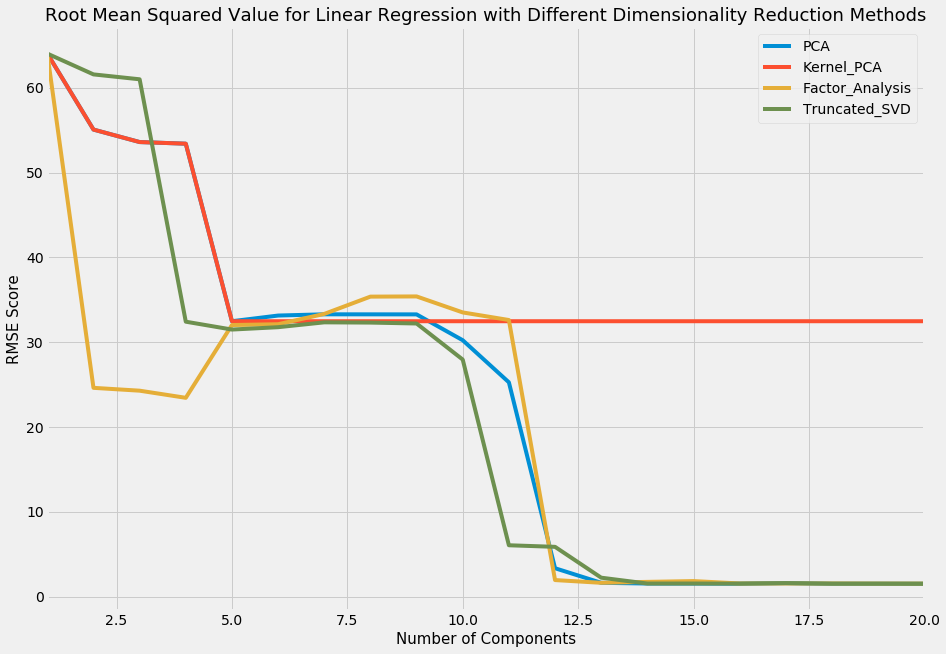

In [95]:
plt.style.use('fivethirtyeight')
plt.subplots(figsize=(14, 10))
for col in dim_red_lr_rmse.columns:
    dim_red_lr_rmse[col].plot(label=col)
plt.legend(loc='best')
plt.ylabel("RMSE Score", size = 15)
plt.xlabel("Number of Components", size = 15)
plt.title("Root Mean Squared Value for Linear Regression with Different Dimensionality Reduction Methods", size = 18)
plt.savefig('dim_red_rmse_lr.png')
plt.show()

Let's also see what the results like with just original variables

In [96]:
X_train.columns

Index(['aroon_down', 'aroon_up', 'aroon_bandwidth', 'bbands_lower',
       'bbands_upper', 'bbandwidth_100', 'cci', 'macd_hist', 'obv', 'rsi',
       'sma_100', 'sma_20', 'stoch', 'today_value', 'crudeoil_open',
       'dollar_open', 'fedfund_open', 'gold_open', 'treasury_3_month',
       'treasury_10_year'],
      dtype='object')

In [97]:
def make_combinations(data):
    num_var = len(data.columns)
    combinations = []
    for i in range(1, num_var + 1):
        for combination in itertools.combinations(data.columns, i):
            combinations.append(combination)
    return combinations
        
column_combinations = make_combinations(X_train[kept_cols])

In [98]:
len(column_combinations)

4095

In [99]:
column_combinations

[('today_value',),
 ('sma_100',),
 ('bbands_upper',),
 ('sma_20',),
 ('obv',),
 ('bbands_lower',),
 ('bbandwidth_100',),
 ('gold_open',),
 ('stoch',),
 ('treasury_10_year',),
 ('rsi',),
 ('macd_hist',),
 ('today_value', 'sma_100'),
 ('today_value', 'bbands_upper'),
 ('today_value', 'sma_20'),
 ('today_value', 'obv'),
 ('today_value', 'bbands_lower'),
 ('today_value', 'bbandwidth_100'),
 ('today_value', 'gold_open'),
 ('today_value', 'stoch'),
 ('today_value', 'treasury_10_year'),
 ('today_value', 'rsi'),
 ('today_value', 'macd_hist'),
 ('sma_100', 'bbands_upper'),
 ('sma_100', 'sma_20'),
 ('sma_100', 'obv'),
 ('sma_100', 'bbands_lower'),
 ('sma_100', 'bbandwidth_100'),
 ('sma_100', 'gold_open'),
 ('sma_100', 'stoch'),
 ('sma_100', 'treasury_10_year'),
 ('sma_100', 'rsi'),
 ('sma_100', 'macd_hist'),
 ('bbands_upper', 'sma_20'),
 ('bbands_upper', 'obv'),
 ('bbands_upper', 'bbands_lower'),
 ('bbands_upper', 'bbandwidth_100'),
 ('bbands_upper', 'gold_open'),
 ('bbands_upper', 'stoch'),
 ('

In [100]:
# I will make a custom function to iteratively evaluate rmse score for each variable combination

def evaluate_combinations(X_train, y_train, X_validation, y_validation, combinations, model):
    combination_evaluation = {}
    iter_num = 1
    start_time = time.perf_counter()
    for c in combinations:
        model.fit(X_train[list(c)], y_train)
        y_val_pred = model.predict(X_validation[list(c)])
        rmse = np.sqrt(mean_squared_error(y_validation, y_val_pred))
        combination_evaluation[c] = rmse
        iter_num += 1
        if iter_num % 100 == 0:
            iter_time = time.perf_counter()
            print("Iteration {}: rmse -- {}".format(iter_num, rmse))
            print("Time spent: {} seconds".format(str(round(iter_time - start_time, 2))))
    return combination_evaluation
    

In [102]:
lr = LinearRegression(n_jobs=-1)
combination_evaluation_lr = evaluate_combinations(X_train, y_train, X_validation, y_validation, column_combinations, lr)

Iteration 100: rmse -- 1.4971207528097275
Time spent: 0.32 seconds
Iteration 200: rmse -- 27.051361428712674
Time spent: 0.7 seconds
Iteration 300: rmse -- 1.4988944837434215
Time spent: 1.01 seconds
Iteration 400: rmse -- 1.6115726231458474
Time spent: 1.33 seconds
Iteration 500: rmse -- 25.941640361604783
Time spent: 1.66 seconds
Iteration 600: rmse -- 28.549581945650072
Time spent: 1.98 seconds
Iteration 700: rmse -- 26.74821127306469
Time spent: 2.3 seconds
Iteration 800: rmse -- 1.5051600191606316
Time spent: 2.63 seconds
Iteration 900: rmse -- 1.49619785820042
Time spent: 2.96 seconds
Iteration 1000: rmse -- 1.498499382403815
Time spent: 3.28 seconds
Iteration 1100: rmse -- 1.5561205648687402
Time spent: 3.62 seconds
Iteration 1200: rmse -- 32.70707083164311
Time spent: 3.95 seconds
Iteration 1300: rmse -- 33.89003702490775
Time spent: 4.28 seconds
Iteration 1400: rmse -- 31.209658115732772
Time spent: 4.61 seconds
Iteration 1500: rmse -- 28.166873171522795
Time spent: 4.94 secon

In [109]:
combination_evaluation_lr_df = pd.DataFrame(np.column_stack((list(combination_evaluation_lr.keys()),
                                                           list(combination_evaluation_lr.values()))),
                                           columns = ["variable_combinations", "rmse_scores"])

In [117]:
# We can now see all variable combinations that yield small rmse scores
combination_evaluation_lr_df.sort_values(by="rmse_scores").head(20)

,variable_combinations,rmse_scores
417,"(today_value, obv, bbandwidth_100, macd_hist)",1.4836
1071,"(today_value, obv, bbandwidth_100, gold_open, macd_hist)",1.48545
111,"(today_value, obv, macd_hist)",1.48576
892,"(today_value, sma_100, bbands_lower, rsi, macd_hist)",1.4858
106,"(today_value, obv, bbandwidth_100)",1.48599
1057,"(today_value, obv, bbands_lower, bbandwidth_100, macd_hist)",1.48606
442,"(today_value, bbands_lower, rsi, macd_hist)",1.4862
451,"(today_value, bbandwidth_100, treasury_10_year, macd_hist)",1.48621
327,"(today_value, sma_100, bbands_lower, macd_hist)",1.48643
15,"(today_value, obv)",1.48646
